In [1]:
using WindTunnelFlow
using Plots
using Plots.PlotMeasures

wtflow_dir = dirname(pathof(WindTunnelFlow))
include(joinpath(wtflow_dir,"../examples/AFUWT_postprocessing.jl"));

In [2]:
root_dir = "/u/home/b/beckers/project-sofia/WindTunnelFlow_simulations"
# case = "cawt_job_5903718_3_AFUWT_flat_plate_gaussian_suction_Grid_Re_2.5_Re_400_aoa_0_Qratio_0.2"
# case = "cawt_job_5903719_3_AFUWT_naca0009_gaussian_suction_Grid_Re_2.5_Re_400_aoa_0_Qratio_0.2"
case = "cawt_job_5903718_15_AFUWT_flat_plate_gaussian_suction_Grid_Re_2.5_Re_400_aoa_10_Qratio_0.4"
# case = "cawt_job_5905452_1_AFUWT_naca0009_gust_from_file_Grid_Re_2.5_Re_400_aoa_0"
# case = "cawt_job_5903715_1_AFUWT_flat_plate_gust_from_file_Grid_Re_2.5_Re_400_aoa_0"

dir = joinpath(root_dir,case)
cd(dir)

In [3]:
json_file = ""
for test_json_file in ["AFUWT_gaussian_suction.json","AFUWT_step_opening_closing.json","AFUWT_gust_from_file.json"]
    test_json_file = joinpath(dir,test_json_file)
    if isfile(test_json_file)
        json_file = test_json_file
    end
end
println(json_file)

/u/home/b/beckers/project-sofia/WindTunnelFlow_simulations/cawt_job_5903718_15_AFUWT_flat_plate_gaussian_suction_Grid_Re_2.5_Re_400_aoa_10_Qratio_0.4/AFUWT_gaussian_suction.json


In [4]:
Q_and_V_probe_file = find_file(dir,"Q_and_V_probe.txt")
force_wind_tunnel_file = find_file(dir,"force_wind_tunnel.txt")
force_viscous_flow_file = find_file(dir,"force_viscous_flow.txt")

t_wt, fx_wt, fy_wt = columns(readdlm(force_wind_tunnel_file, '\t', Float64, '\n'));
t_nwt, fx_nwt, fy_nwt = columns(readdlm(force_viscous_flow_file, '\t', Float64, '\n'));
t_Q, Qratio, _, Umid, _, Umean, _, Vmid, _, Vmean = columns(readdlm(Q_and_V_probe_file, '\t', Float64, '\n'));
# t_Q, Qratio, _, Umean, _, _, Vmean, _ = columns(readdlm(Q_and_V_probe_file, '\t', Float64, '\n'));

In [5]:
# Create the wind tunnel problem
inputs = JSON.parsefile(json_file);
include("/u/home/b/beckers/.julia/dev/WindTunnelFlow/examples/AFUWT_create_sys.jl")

wt_walls = create_windtunnel_boundaries(g,params,withinlet=true);

Reading existing grid from 5903718_15_grid.json:
PhysicalGrid{2}((1512, 448), (756, 224), 0.00625, ((-4.71875, 4.71875), (-1.39375, 1.39375)), 1)
creating flat plate airfoil
creating gaussian gust
Creating WindTunnelProblem... done


In [6]:
if occursin("step_opening_closing",lowercase(gust_type))
    t_gust_start = params["t_open"]
    t_gust_end = params["t_close"] + params["tau_close"] + 2 * V_in_star / c_star
elseif occursin("gust_from_file",lowercase(gust_type))
    t_gust_start = inputs["t_gust_start"]
    t_gust_end = inputs["t_gust_end"]
else # Gaussian suction
    t_gust_start = params["t_suction"] - 4 * params["sigma_suction"]
    t_gust_end = params["t_suction"] + 4 * params["sigma_suction"] + 0.5 * V_in_star / c_star
end
suction_idxs = findall(t->t_gust_start <= t <= t_gust_end,t_wt);

In [7]:
function interpolate_probed_velocity(t,phys_params)
    U_interp  = phys_params["Umid_interp"]
    V_interp  = phys_params["Vmid_interp"]
    return U_interp(t), V_interp(t)
end

params["Umid_interp"] = LinearInterpolation(t_wt,Umid,extrapolation_bc=Line());
params["Vmid_interp"] = LinearInterpolation(t_wt,Vmid,extrapolation_bc=Line());

In [30]:
Δt_wagner = 0.0025
t_wagner = t_gust_start:Δt_wagner:t_gust_end
U_wagner = [interpolate_probed_velocity(t+Δt_wagner,params)[1] for t in t_wagner];
V_wagner = -[interpolate_probed_velocity(t+Δt_wagner,params)[2] for t in t_wagner];
if !occursin("file",lowercase(gust_type))
    fy_wagner, added_mass, fy_wagner_circ = wagner_lift_response(t_wagner, U_wagner[1], V_wagner, α; steadystart=true, steadycirc=fy_wt[suction_idxs[1]]);
else
    fy_wagner, added_mass, fy_wagner_circ = wagner_lift_response(t_wagner, U_wagner[1], V_wagner, α; steadystart=true);
end

if !occursin("flat",lowercase(airfoil_name))
    airfoil_volume = volume(airfoil);
    fy_reference_correction = airfoil_volume * backward_difference(t_wagner,-V_wagner);
end;

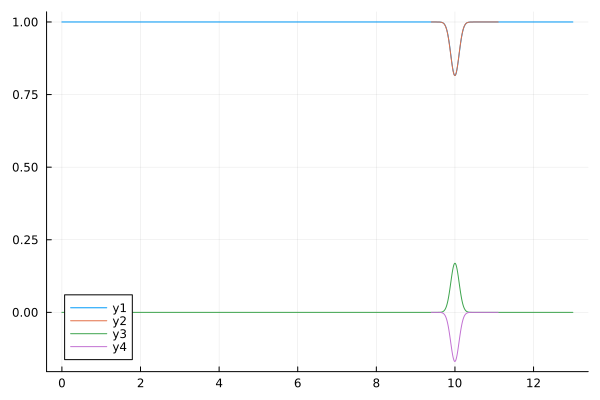

In [31]:
plot(t_Q, Umid)
plot!(t_wagner,U_wagner)
plot!(t_Q, Vmid)
plot!(t_wagner,V_wagner)

In [32]:
idx_wagner_common = findall(t->t in t_wt, t_wagner)
idx_wt_common = findall(t->t in t_wagner, t_wt)
t_wt_circ = t_wt[idx_wt_common]
if occursin("flat",lowercase(airfoil_name))
    fy_wt_circ = fy_wt[idx_wt_common] - added_mass[idx_wagner_common];
else
    fy_wt_circ = fy_wt[idx_wt_common] - added_mass[idx_wagner_common] - fy_reference_correction[idx_wagner_common];
end

idx_wagner_common = findall(t->t in t_nwt, t_wagner)
idx_nwt_common = findall(t->t in t_wagner, t_nwt)
t_nwt_circ = t_wt[idx_nwt_common]
if occursin("flat",lowercase(airfoil_name))
    fy_nwt_circ = fy_nwt[idx_wt_common] - added_mass[idx_wagner_common];
else
    fy_nwt_circ = fy_nwt[idx_wt_common] - added_mass[idx_wagner_common] - fy_reference_correction[idx_wagner_common];
end;

In [33]:
# plot(t_wagner,dVdt)

In [34]:
# 1.645*dVdt_mid_star_std_wagner

In [35]:
V_SD_star_var = 6.550919100696533e-6;
V_mid_star_over_V_SD_star = 0.2909318504876581;
V_mid_star_std = sqrt(V_SD_star_var) * V_mid_star_over_V_SD_star
dVdt_mid_star_std_wagner = sqrt(2) * V_mid_star_std / Δt_wagner
added_mass_std_wagner = π/4 * cos(α) * dVdt_mid_star_std_wagner

circ_std_wagner = π * V_mid_star_std * (length(0.0:Δt_wagner:t_gust_start) .+ (1:length(t_gust_start:Δt_wagner:t_gust_end)))

8.800575059210663:0.0023393341465206443:10.3913222788447

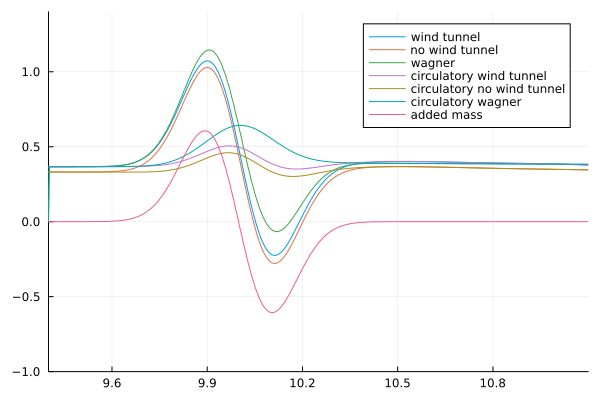

In [36]:
p=plot(t_wt,fy_wt,label="wind tunnel",xlim=[t_gust_start,t_gust_end],ylim=[-1,1.4])
plot!(t_nwt,fy_nwt,label="no wind tunnel")
plot!(t_wagner,fy_wagner,label="wagner")
plot!(t_wt_circ,fy_wt_circ,label="circulatory wind tunnel")
plot!(t_nwt_circ,fy_nwt_circ,label="circulatory no wind tunnel")
plot!(t_wagner,fy_wagner_circ,label="circulatory wagner")
plot!(t_wagner,added_mass,label="added mass")
if !occursin("flat",lowercase(airfoil_name))
    plot!(t_wagner,fy_reference_correction,label="reference correction")
end
p

In [37]:
if !occursin("file",lowercase(gust_type))
    output_file_prefix = "$(lowercase(airfoil_name))_$(lowercase(gust_type))_aoa_$(α)_Qratio_$(inputs["Q_SD_over_Q_in"])"
else
    output_file_prefix = "$(lowercase(airfoil_name))_$(lowercase(gust_type))_aoa_$(α)"
end

write_body("$(lowercase(airfoil_name))_airfoil_$(α)_degrees.txt",airfoil)
write_arrays("$(output_file_prefix)_c_l_wt.txt",t_wt,2*fy_wt)
write_arrays("$(output_file_prefix)_c_l_nwt.txt",t_nwt,2*fy_nwt)
write_arrays("$(output_file_prefix)_c_l_wagner.txt",t_wagner,2*fy_wagner)
write_arrays("$(output_file_prefix)_c_l_wt_circ.txt",t_wt_circ,2*fy_wt_circ)
write_arrays("$(output_file_prefix)_c_l_nwt_circ.txt",t_nwt_circ,2*fy_nwt_circ)
write_arrays("$(output_file_prefix)_c_l_wagner_circ.txt",t_wagner,2*fy_wagner_circ)
write_arrays("$(output_file_prefix)_c_l_added_mass.txt",t_wagner,2*added_mass)
write_arrays("$(output_file_prefix)_Q_ratio.txt",t_wt,Qratio)
if occursin("naca",lowercase(airfoil_name))
    write_force("$(output_file_prefix)_c_l_buoyancy.txt",t_wagner,2*fy_reference_correction)
end

In [38]:
dVdt = backward_difference(t_wagner,-V_wagner);
write_arrays("$(output_file_prefix)_dVdt.txt",t_wagner,dVdt)

In [39]:
snapshot_times = parse.(Float64,(split(inputs["snapshot_times"],' ')))
snapshot_idx = [findmin(abs.(snapshot_times[i] .- t_wt))[2] for i in 1:length(snapshot_times)];

In [18]:
fig_xlim = [-0.75,2.75]
fig_ylim = ylim

y_probe_ψ = range(ỹ_O_WT_star,ỹ_O_WT_star+H_TS_star,30)
x_probe_ψ = zeros(length(y_probe_ψ)) .+ x̃_O_WT_star

x_probe_ψ = cat(x_probe_ψ, range(-0.5*cos((α-1)*π/180),-0.5*cos((α+1)*π/180),4), dims=1)
y_probe_ψ = cat(y_probe_ψ, range(0.5*sin((α-1)*π/180),0.5*sin((α+1)*π/180),4), dims=1)

plot_list = []

x_nodes = x_gridcurl(sys)
y_nodes = y_gridcurl(sys)
v = zeros_grid(sys)
w = zeros_gridcurl(sys)
ψ = zeros_gridcurl(sys)
Q = Nodes(Dual,size(g))
Ssq = Nodes(Primal,size(g))
∇v = EdgeGradient(Primal,Dual,size(g));

w.data .= read_file_with_patterns(dir,["snapshot_$(snapshot_idx[1])","vorticity","wind_tunnel"])
t_1 = read_file_with_patterns(dir,["snapshot_$(snapshot_idx[1])","time","wind_tunnel"])[1]
ViscousFlow.velocity!(v, w, sys, t_1);
grad!(∇v,v)
∇v ./= cellsize(sys)
q_criterion!(Q,Ssq,∇v);

offset = 0.1
probe_points = deepcopy(points(airfoil))
if occursin("naca0009",lowercase(airfoil_name))
    probe_points = VectorData(probe_points.u[1:end÷4],probe_points.v[1:end÷4])
else
    probe_points = VectorData(probe_points.u[end÷4:end],probe_points.v[end÷4:end])
end
probe_points.u .+= offset * sin(α*pi/180)
probe_points.v .+= offset * cos(α*pi/180)

Q_fcn = interpolatable_field(Q,g)
Q_probe = Q_fcn.(probe_points.u,probe_points.v)
Q_mean = mean(Q_probe)
Q_std = std(Q_probe)
Q_levels = range(Q_mean,Q_mean+3Q_std,10)

println(Q_levels)

for i in 1:length(snapshot_idx)
    println("i = $(i)")
    w.data .= read_file_with_patterns(dir,["snapshot_$(snapshot_idx[i])","vorticity","wind_tunnel"])
    t_i = read_file_with_patterns(dir,["snapshot_$(snapshot_idx[i])","time","wind_tunnel"])[1]
    ViscousFlow.streamfunction!(ψ,w,sys,t_i);

    ψ_fcn = interpolatable_field(ψ,g)
    ψ_probe = ψ_fcn.(x_probe_ψ,y_probe_ψ)

    ViscousFlow.velocity!(v, w, sys, t_i);
    grad!(∇v,v)
    ∇v ./= cellsize(sys)
    q_criterion!(Q,Ssq,∇v);
    
    write_contours("$(output_file_prefix)_Q_contour_$(i).txt", x_nodes, y_nodes, Q, Q_levels, fig_xlim, [0.5*fig_ylim[1],0.5*fig_ylim[2]], closed=true)
    write_contours("$(output_file_prefix)_psi_contour_$(i).txt", x_nodes, y_nodes, ψ, ψ_probe, fig_xlim, [ỹ_O_WT_star, ỹ_O_WT_star+H_TS_star])

    p = plot(ψ,g,c=:gray,xlim=fig_xlim,ylim=fig_ylim,levels=ψ_probe)
    plot!(Q,g,xlim=fig_xlim,ylim=fig_ylim,levels=Q_levels,c=:black)
    plot!(airfoil,fc=:white,lc=:black)
    plot!(wt_walls,c=:black)

    push!(plot_list,p)
end

0.5942021702737632:0.2735624036038884:3.0562638027087585
i = 1
i = 2
i = 3
i = 4


In [19]:
p = plot(plot_list..., layout = (4, 1), size=(500,1000),titlefontsize=10, link=:x)
plot!(xformatter=_->"",subplot=1,bottom_margin = -5px)
plot!(xformatter=_->"",subplot=2,bottom_margin = -5px)
plot!(xformatter=_->"",subplot=3,bottom_margin = -5px)
# savefig("$(inputs["case"])_snapshots_4_1.pdf")
p

In [20]:
# ViscousFlow.jl simulation
params["freestream"] = interpolate_probed_velocity
viscous_prob = ViscousIncompressibleFlowProblem(
    g,
    airfoil,
    phys_params=params;
    timestep_func=ViscousFlow.DEFAULT_TIMESTEP_FUNC,
    bc=ViscousFlow.get_bc_func(nothing))
viscous_sys = construct_system(viscous_prob);

In [21]:
plot_list = []

for i in 1:length(snapshot_idx)
    println("i = $(i)")
    w.data .= read_file_with_patterns(dir,["snapshot_$(snapshot_idx[i])","vorticity","viscous"])
    t_i = read_file_with_patterns(dir,["snapshot_$(snapshot_idx[i])","time","viscous"])[1]
    ViscousFlow.streamfunction!(ψ,w,viscous_sys,t_i);
    
    if t_gust_start <= t_i < t_gust_end
        y_probe_ψ = range(fig_ylim[1],fig_ylim[2],30)
        x_probe_ψ = range(fig_xlim[2],fig_xlim[1],30)
        x_probe_ψ = cat(x_probe_ψ, range(-0.5*cos((α-1)*π/180),-0.5*cos((α+1)*π/180),4), dims=1)
        y_probe_ψ = cat(y_probe_ψ, range(0.5*sin((α-1)*π/180),0.5*sin((α+1)*π/180),4), dims=1)
    else
        y_probe_ψ = range(fig_ylim[1],fig_ylim[2],30)
        x_probe_ψ = range(xlim[1],xlim[1],30)
        x_probe_ψ = cat(x_probe_ψ, range(-0.5*cos((α-1)*π/180),-0.5*cos((α+1)*π/180),4), dims=1)
        y_probe_ψ = cat(y_probe_ψ, range(0.5*sin((α-1)*π/180),0.5*sin((α+1)*π/180),4), dims=1)
    end

    ψ_fcn = interpolatable_field(ψ,g)
    ψ_probe = ψ_fcn.(x_probe_ψ,y_probe_ψ)

    ViscousFlow.velocity!(v, w, viscous_sys, t_i);
    grad!(∇v,v)
    ∇v ./= cellsize(sys)
    q_criterion!(Q,Ssq,∇v);
    
    write_contours("$(output_file_prefix)_Q_contour_viscous_flow_$(i).txt", x_nodes, y_nodes, Q, Q_levels, fig_xlim, [0.5*fig_ylim[1],0.5*fig_ylim[2]], closed=true)
    write_contours("$(output_file_prefix)_psi_contour_viscous_flow_$(i).txt", x_nodes, y_nodes, ψ, ψ_probe, fig_xlim, fig_ylim)

    p = plot(ψ,g,c=:gray,xlim=fig_xlim,ylim=fig_ylim,levels=ψ_probe)
    plot!(Q,g,xlim=fig_xlim,ylim=fig_ylim,levels=Q_levels,c=:black)
    plot!(airfoil,fc=:white,lc=:black)
    scatter!(x_probe_ψ,y_probe_ψ)

    push!(plot_list,p)
end

i = 1
i = 2
i = 3
i = 4


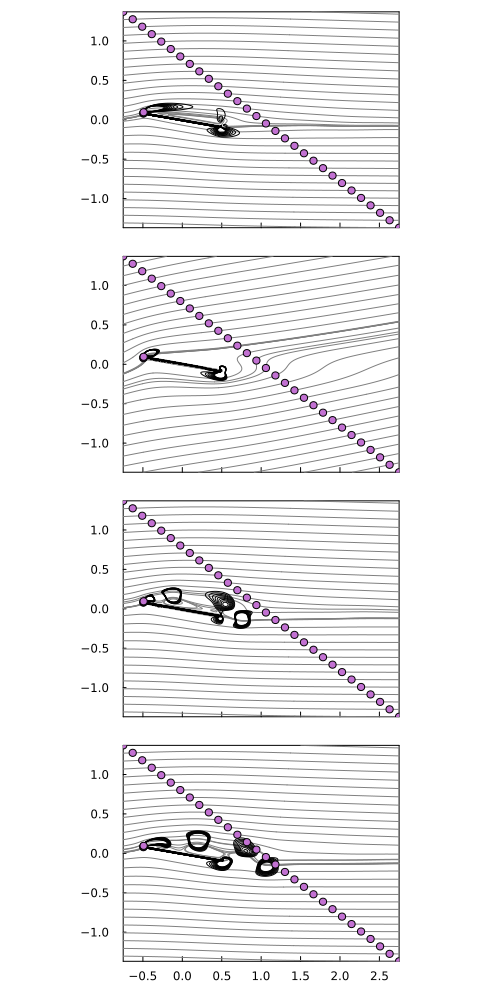

In [22]:
p = plot(plot_list..., layout = (4, 1), size=(500,1000),titlefontsize=10, link=:x)
plot!(xformatter=_->"",subplot=1,bottom_margin = -5px)
plot!(xformatter=_->"",subplot=2,bottom_margin = -5px)
plot!(xformatter=_->"",subplot=3,bottom_margin = -5px)
# savefig("$(inputs["case"])_snapshots_4_1.pdf")
p